In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a89nej7x because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [20]:
def weights(signed_dists):
    #The weight for a specific point in any localized subset of data is obtained by evaluating 
    # the weight function at the distance between that point and the point of estimation, 
    # after scaling the distance so that the maximum absolute distance over all of the points 
    # in the subset of data is exactly one.
    minscale = None # later, when this breaks, try with 1e-8
    scale = np.max(np.max(signed_dists),0) - np.min(np.min(signed_dists),0)# np.clip(,minscale, None)
    # https://www.itl.nist.gov/div898/handbook/pmd/section1/pmd144.htm
    weight = np.clip((1-(np.abs(signed_dists)/scale)**3)**3,0,1)
    #weight = np.ones(len(signed_dists)).reshape(-1,1)set weights equal for testing
    return weight

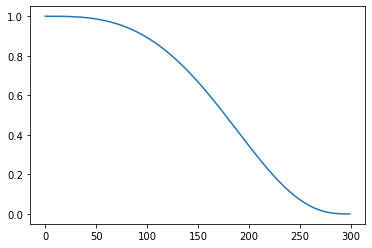

In [21]:
x = np.arange(0,3,0.01)
plt.plot(weights(x))

In [22]:
def safe_divide_arrays(ns,ds):
    res = []
    for i in range(len(ns)):
        n = ns.flatten()[i]
        d = ds.flatten()[i]
        res.append(0 if (np.any(d == 0) or np.any(np.isnan(d))) else n/d)
    return np.array(res)

In [61]:
# learn how to do this ourselves. yay.
def fit_1d_lowess_with_confidence_bounds(x,y,x_target, q):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    N = len(x)
    n_neighbors = int(np.ceil(q*N))
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(x.reshape(-1,1))
    means = []
    stds = []
    resid_point_stds = []
    # we'll be fitting a new linear model at each of the x_target points
    for xtar in x_target:
        xtar = xtar.reshape(1,1)
        distances, indices = nbrs.kneighbors(xtar)
        indices = indices.flatten()
        signed_distances = (x[indices] - xtar)
        y_subset = y[indices]
        w = weights(signed_distances)
        w = w/np.sum(w)
        wx = np.sqrt(w) * signed_distances
        
        Y  = np.sqrt(w) * y_subset
        X = np.concatenate((np.sqrt(w),wx),axis=1)
        
        n_effective = np.sum(w)/np.sum(np.square(w))
        invcovmat = np.linalg.inv(X.T @ X)
        beta = invcovmat @ X.T @Y
        residual = (Y - X@beta)
        #print(residual/np.sqrt(w))
        residual_variance = np.sum(np.square(residual)) # sum has scale w inside it so it is already like a mean
        # note: R uses len(residual)-2 instead of n_effective-2 here. Weird.
        residual_SE = np.sqrt(residual_variance/(n_effective-2))
        intercept_SE = np.sqrt(invcovmat[0,0]) * residual_SE
        print(f"residual_variance:{residual_variance}")
        print(f"mean:{beta[0,0]}, residual_SE:{residual_SE}, intercept_SE:{intercept_SE}, np.sqrt(invcovmat[0,0]):{np.sqrt(invcovmat[0,0])}")
        means.append(beta[0,0])
        stds.append(intercept_SE)
        resid_point_stds.append(residual_SE*np.sqrt(n_effective-2))
    means = np.array(means)
    stds = np.array(stds)
    resid_point_stds = np.array(resid_point_stds)
    return(means,stds,resid_point_stds)

In [62]:
fit_1d_lowess_with_confidence_bounds(np.arange(9),np.array((0,1,2,3,4,3,2,1,0)), np.arange(2),1.)

residual_variance:0.5868978450068995
mean:0.5289453740617498, residual_SE:0.3771781809213435, intercept_SE:0.6162207207290245, np.sqrt(invcovmat[0,0]):1.6337655567025782
residual_variance:1.0482037478183073
mean:1.3186348313572531, residual_SE:0.4534916033133102, intercept_SE:0.5999367327424961, np.sqrt(invcovmat[0,0]):1.3229279844637154


(array([0.52894537, 1.31863483]),
 array([0.61622072, 0.59993673]),
 array([0.76609258, 1.02381822]))

In [63]:
X = np.linspace(0,1,1000)
Y = np.random.normal(size=1000)
targxs = np.array((0.25,0.5,0.75))
m,s,ps = fit_1d_lowess_with_confidence_bounds(X,Y, targxs,0.5)

residual_variance:1.0549164941081597
mean:-0.021239915601279212, residual_SE:0.04628342326328111, intercept_SE:0.0462834643652296, np.sqrt(invcovmat[0,0]):1.000000888049016
residual_variance:0.9177348035235545
mean:0.019210863017013233, residual_SE:0.043169296943480935, intercept_SE:0.043169296943480935, np.sqrt(invcovmat[0,0]):1.0
residual_variance:0.916443450723531
mean:0.03946946469613642, residual_SE:0.04313891996199112, intercept_SE:0.04313895827146656, np.sqrt(invcovmat[0,0]):1.0000008880490163


In [65]:
print(m,s,ps)

[-0.02123992  0.01921086  0.03946946] [0.04628346 0.0431693  0.04313896] [1.02709128 0.95798476 0.95731053]


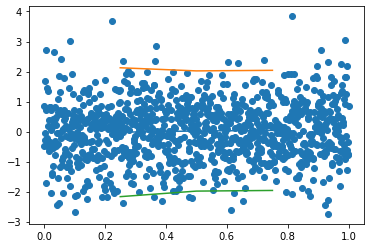

In [66]:
plt.plot(targxs,m)
plt.plot(targxs,m+2*(s+ps))
plt.plot(targxs,m-2*(s+ps))
plt.scatter(X,Y)